<a href="https://colab.research.google.com/github/darren-source/RSNA_Pneumonia/blob/main/Copy_of_Untitled100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving How-is-Data-Science-Changing-the-Healthcare-Industry.jpg to How-is-Data-Science-Changing-the-Healthcare-Industry.jpg


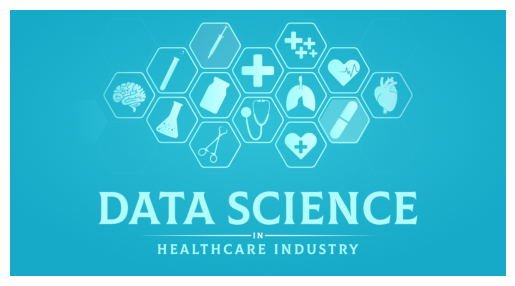

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open('/content/How-is-Data-Science-Changing-the-Healthcare-Industry.jpg')

plt.imshow(image)
plt.axis('off')
plt.show()


# **RSNA Pneumonia Detection Challenge**

## **Problem**

The goal of this project is to develop a machine learning algorithm that **localizes lung opacities** that indicate pneumonia in chest X-rays. The significance of the model's accuracy is to **improve the diagnosis of pneumonia** in the community. Pneumonia remains a major global health challenge, especially among the elderly, contributing to **old age mortality**.

---

## **Data Source**

The data was sourced with the help of the **Radiological Society of North America**, **The US National Institutes of Health**, and the **Society of Thoracic Radiology** and **MD**. The dataset includes chest X-rays with lung opacities, along with additional data such as patient demographics and clinical history.

---

## **Data Collection and Labelling Method**

The data was collected from multiple clinical hospitals to ensure a **diverse set of data**. The labeled data was annotated by **trained radiologists**, indicating areas of the X-ray that contained lung opacities relevant to a pneumonia diagnosis.

---

## **Ethics of the Data**

To ensure that the data collection and usage comply with ethical standards:
- **Patient privacy and data security** were strictly maintained.
- Medical professionals ensured that the dataset is appropriate for developing diagnostic tools.


In [ ]:
# Import the file from Google Colab to upload files
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"darrencampbell","key":"d7ffc746c3a9d98e02aaaa848c4dca9e"}'}

In [ ]:
# Create directory named .kaggle to store Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Use Kaggle API to download the dataset for the RSNA Pneumonia Detection Challenge
!kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.66G/3.66G [02:14<00:00, 33.4MB/s]
100% 3.66G/3.66G [02:14<00:00, 29.2MB/s]


In [ ]:
# Unzip the downloaded dataset
!unzip -q rsna-pneumonia-detection-challenge.zip

In [ ]:
# List the files in the current directory
!ls

'GCP Credits Request Link - RSNA.txt'			    stage_2_detailed_class_info.csv
 How-is-Data-Science-Changing-the-Healthcare-Industry.jpg   stage_2_sample_submission.csv
 kaggle.json						    stage_2_test_images
 rsna-pneumonia-detection-challenge.zip			    stage_2_train_images
 sample_data						    stage_2_train_labels.csv


# **Dataset Files Overview**

### **1. `stage_2_sample_submission.csv`**
- **Description**: A sample submission file that provides the format for how you should submit your predictions.

---

### **2. `stage_2_test_images/`**
- **Description**: Folder containing the test chest X-ray images.

---

### **3. `stage_2_train_images/`**
- **Description**: Folder containing the training chest X-ray images.

---

### **4. `stage_2_train_labels.csv`**
- **Description**: CSV file that contains the labels for the training data, indicating:
  - Whether pneumonia is present.
  - Bounding box coordinates for the lung opacities (if applicable).

---

### **5. `stage_2_detailed_class_info.csv`**
- **Description**: CSV file providing additional class information with more detailed labels on the types of lung opacity.

In [ ]:
# Libraries for data manipulation and analysis
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
# Libraries for working with DICOM images and image processing
!pip install pydicom
import pydicom
from PIL import Image
# TensorFlow and Keras libraries for building and training deep learning models
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Optimizers and pre-trained models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
# Libraries for evaluating model performance
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 49.8 MB/s eta 0:00:00


# **Data Exploration**

The **RSNA Pneumonia Dataset** consists of **30,227** professionally labeled chest X-rays. Of these, **26,684** are unique images, indicating the presence of some duplicate images in the dataset.

Each X-ray record includes:
- **Bounding box coordinates** (`x`, `y`, `width`, `height`) to identify opacities that may be showing signs of pneumonia.
- A binary **Target** label indicating pneumonia presence:
  - **1**: Pneumonia present
  - **0**: Pneumonia absent

### **Class Distribution:**
- Of the total unique entries:
  - **9,555** are positive for pneumonia.
  - **20,672** are negative for pneumonia.
  
This gives an approximate class ratio of **1:2** (positive to negative cases).

In [ ]:
# Load the training labels and sample submission data
train_labels = pd.read_csv('stage_2_train_labels.csv')
sample_submission = pd.read_csv('stage_2_sample_submission.csv')

In [ ]:
# Print the first few rows of the train_labels dataset
print(train_labels.head())
# Print the shape (rows, columns) of the train_labels dataset
print(train_labels.shape)

                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
(30227, 6)


In [ ]:
# Calculate the number of unique images in the dataset
num_images = train_labels['patientId'].nunique()
print(f'Number of unique images: {num_images}')

Number of unique images: 26684


In [ ]:
# Count the number of positive cases
num_positive_cases = train_labels[train_labels['Target'] == 1].shape[0]

# Count the number of negative cases
num_negative_cases = train_labels[train_labels['Target'] == 0].shape[0]

# Print the number of positive and negative cases
print(f'Number of positive cases (pneumonia): {num_positive_cases}')
print(f'Number of negative cases (no pneumonia): {num_negative_cases}')

Number of positive cases (pneumonia): 9555
Number of negative cases (no pneumonia): 20672


# **X-ray Analysis**

- The average size of the X-ray images is **1024 x 1024 pixels**.

### **Visual Inspection of X-rays**
- **9 sample X-rays** were visually inspected using **pydicom** and **PIL**.
  - **Pydicom**: Used to visualize DICOM files, the standard format for storing medical images.
  - **PIL**: Used for image processing and display.

### **Pixel Intensity Histogram**
- A **pixel intensity histogram** was generated to display the grayscale values of the X-rays, providing insights into the **contrast** and **brightness**.
  - This is a critical factor in image-based machine learning.
  - Extreme contrast and brightness can result from over- or under-exposure of X-ray images, which may impact model performance.

### **Bounding Box Analysis**
- A histogram was also used to display the distribution of the **bounding box width and height**.
- Upon further examination of the **positive cases** (pneumonia present) with bounding boxes, there was considerable variation in the bounding box sizes.
  - This variation may reflect the differences in pneumonia manifestations across patients, whether caused by **viral** or **bacterial** infections.

In [ ]:
# Define the folder containing the images
image_folder = 'stage_2_train_images'
sample_patient_id = train_labels[train_labels['Target'] == 1]['patientId'].iloc[0]

In [ ]:
# Load and read the DICOM image file
image_path = os.path.join(image_folder, f'{sample_patient_id}.dcm')
ds = pydicom.dcmread(image_path)

In [ ]:
# Convert the pixel array from the DICOM file to an image using PIL
image = Image.fromarray(ds.pixel_array)
print(f'Image size: {image.size}')

Image size: (1024, 1024)


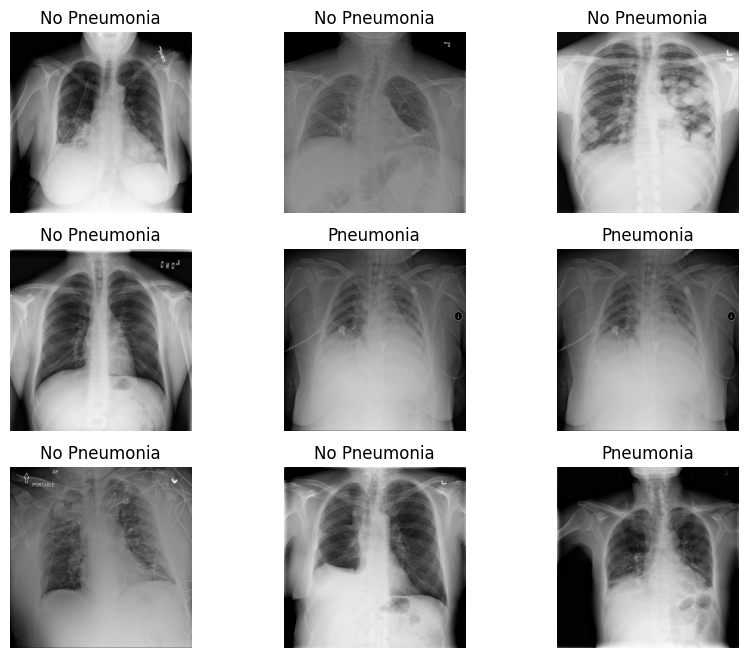

In [ ]:
# Create a 3x3 grid of subplots to display 9 sample DICOM images from the dataset
fig, ax = plt.subplots(3, 3, figsize=(10, 8))
label_dict = {0: 'No Pneumonia', 1: 'Pneumonia'}

# Define the root folder path for the DICOM images
ROOT_PATH = 'stage_2_train_images'

c = 0

# Loop through the first 9 images in the dataset and display them in the grid
for i in range(3):
    for j in range(3):
        patient_id = train_labels.iloc[c]['patientId']
        dcm_path = os.path.join(ROOT_PATH, patient_id + '.dcm')
        dcm_file = pydicom.dcmread(dcm_path).pixel_array
        ax[i][j].imshow(dcm_file, cmap='gray')
        ax[i][j].set_title(label_dict[train_labels.iloc[c]['Target']])
        ax[i][j].axis('off')
        c += 1


In [ ]:
# Filter the training labels for positive cases (pneumonia) and count the unique images
positive_cases_with_boxes = train_labels[train_labels['Target'] == 1]
num_images_with_boxes = positive_cases_with_boxes['patientId'].nunique()
print(f'Number of images with bounding boxes: {num_images_with_boxes}')

Number of images with bounding boxes: 6012


In [ ]:
# Select an image from the dataset and load the DICOM file
sample_image_id = train_labels['patientId'].sample(1).values[0]
image_path = os.path.join('stage_2_train_images', sample_image_id + '.dcm')
ds = pydicom.dcmread(image_path)

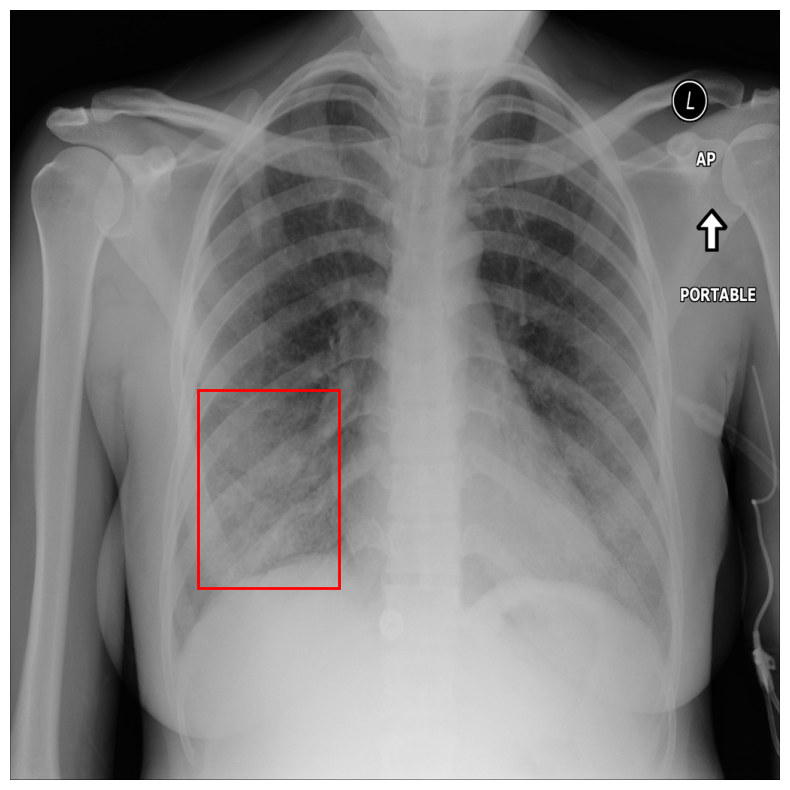

In [ ]:
# Extract the image pixel
image = ds.pixel_array
bbox = train_labels[train_labels['patientId'] == sample_image_id][['x', 'y', 'width', 'height']].values[0]

# Display the image
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image, cmap='gray')

# Add a red rectangle to indicate the bounding box on the image
rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.axis('off')
plt.show()

                 x            y        width       height
count  9555.000000  9555.000000  9555.000000  9555.000000
mean    394.047724   366.839560   218.471376   329.269702
std     204.574172   148.940488    59.289475   157.750755
min       2.000000     2.000000    40.000000    45.000000
25%     207.000000   249.000000   177.000000   203.000000
50%     324.000000   365.000000   217.000000   298.000000
75%     594.000000   478.500000   259.000000   438.000000
max     835.000000   881.000000   528.000000   942.000000


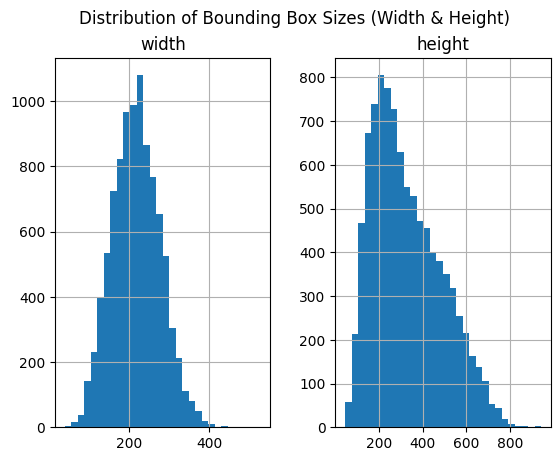

In [ ]:
# Display summary statistics for the bounding box coordinates
print(train_labels[['x', 'y', 'width', 'height']].describe())
# Plot histograms for the width and height of the bounding boxes
train_labels[train_labels['Target'] == 1].hist(column=['width', 'height'], bins=30)
plt.suptitle('Distribution of Bounding Box Sizes (Width & Height)')
plt.show()


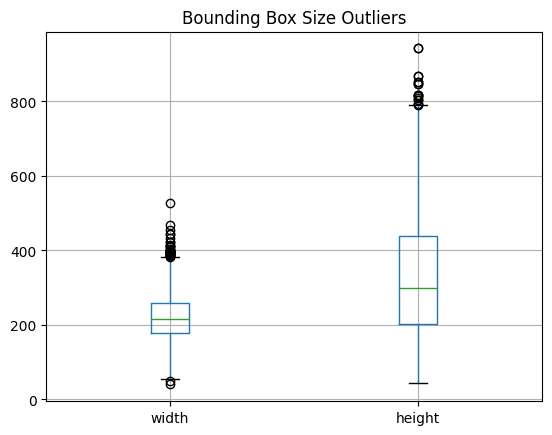

In [ ]:

# Create boxplots for the bounding box width and height for positive cases

train_labels[train_labels['Target'] == 1].boxplot(column=['width', 'height'])
plt.title('Bounding Box Size Outliers')
plt.show()

In [ ]:
# Load a sample DICOM image from the image folder and read the DICOM file
image_path = os.path.join(image_folder, f'{sample_patient_id}.dcm')
ds = pydicom.dcmread(image_path)

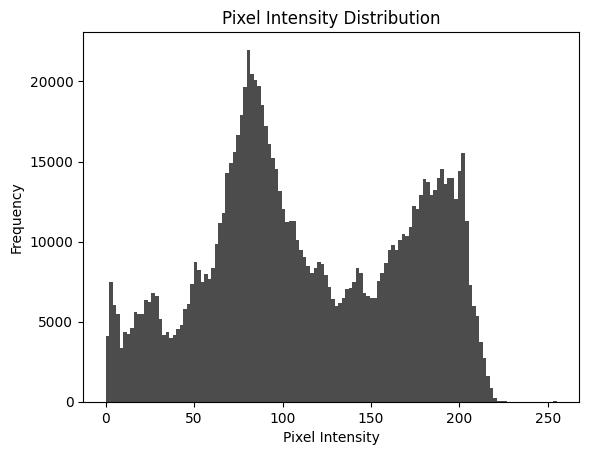

In [ ]:
# Convert the pixel array (image) from the DICOM file into a NumPy array for analysis.
image = np.array(ds.pixel_array)
plt.hist(image.ravel(), bins=128, color='black', alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

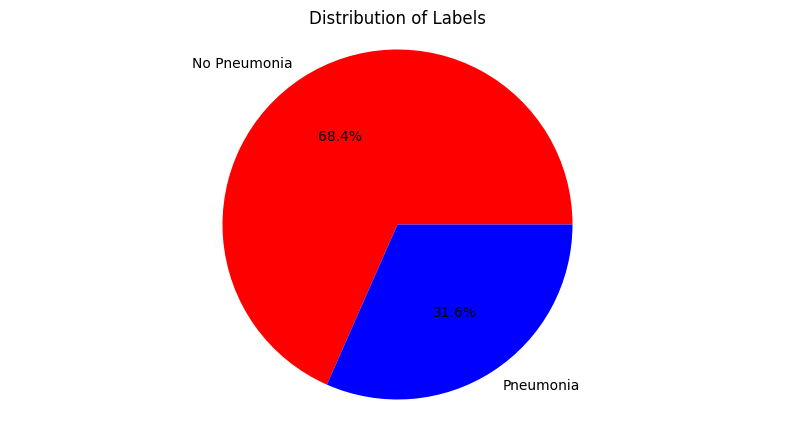

In [ ]:
# Count the number of positive (pneumonia) and negative (no pneumonia) cases in the dataset
label_count = train_labels['Target'].value_counts()

colors = ['red', 'blue']

# Create a pie chart to visualize the distribution of labels
plt.figure(figsize=(10, 5))
plt.pie(label_count, labels=['No Pneumonia', 'Pneumonia'], colors=colors, autopct='%1.1f%%')

plt.title('Distribution of Labels')
plt.axis('equal')

plt.show()

# **What is a DICOM File?**

**DICOM** stands for **Digital Imaging and Communications in Medicine**. It is the standard file format for storing medical imaging data. DICOM files contain:
- **Medical Images** (e.g., X-rays, CT scans, MRI images).
- **Associated Metadata**, such as:
  - **Patient details** (e.g., name, age, medical history).
  - **Equipment details** used to capture the image.

---

### **Why Convert DICOM Files to JPEG?**

Converting **DICOM** files to **JPEG** makes X-ray images easier to work with in **Convolutional Neural Networks (CNNs)** for several reasons:
- **Improves Compatibility**: JPEG is a widely supported format across different libraries and machine learning frameworks.
- **Reduces File Size**: JPEG files are generally smaller than DICOM files, leading to faster data loading and processing.








In [ ]:
# Unique Function created to convert DICOM images to JPEG format
def dicom_to_jpg(dicom_directory, output_directory):

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    files = os.listdir(dicom_directory)
    for file in files:
        if file.endswith('.dcm'):
            full_path = os.path.join(dicom_directory, file)

            dicom_image = pydicom.dcmread(full_path)

            image_array = dicom_image.pixel_array.astype(float)
            image_array -= image_array.min()
            image_array /= image_array.max()
            image_array *= 255.0

            image_array = image_array.astype('uint8')

            pil_image = Image.fromarray(image_array)

            patient_id = file.split('.')[0]
            output_filepath = os.path.join(output_directory, f"{patient_id}.jpg")
            pil_image.save(output_filepath, 'JPEG')

# **Code for Converting DICOM Files to JPEG**

The code used to convert **DICOM files** to **JPEG files** was adapted and modified from the article on **Medium**:

**"DICOM to JPG and extract all patients information using python."**  
by **Vivek Kumar**

---

### **Reference**:
- Original Source: [Medium Article by Vivek Kumar](https://medium.com)
- Purpose: To convert medical imaging data from DICOM format to JPEG, making it easier to work with in machine learning models.


In [ ]:
# Directories for DICOM input and JPEG output
dicom_directory = 'stage_2_train_images'
output_directory = 'JPG_stage_2_train_images'

In [ ]:
# Convert DICOM images to JPEG
dicom_to_jpg(dicom_directory, output_directory)

train_labels['path'] = train_labels['patientId'].apply(lambda x: f"{x}.jpg")

In [ ]:
# Convert 'Target' column to string type
train_labels['Target'] = train_labels['Target'].astype(str)

In [ ]:
# Import ImageDataGenerator for image augmentation and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for rescaling images and split the data for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values from 0-255 to 0-1
    validation_split=0.2  # Reserve 20% of the data for validation
)

In [ ]:
# Create the training data generator, specifying image paths, labels for training
train_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='JPG_stage_2_train_images',
    x_col='path',
    y_col='Target',
    subset='training',
    batch_size=32,
    shuffle=True,
    class_mode='binary',
    target_size=(96, 96)
)

# Create the validation data generator, specifying image paths, labels for validation
validation_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='JPG_stage_2_train_images',
    x_col='path',
    y_col='Target',
    subset='validation',
    batch_size=32,
    shuffle=True,
    class_mode='binary',
    target_size=(96, 96)
)

Found 24182 validated image filenames belonging to 2 classes.
Found 6045 validated image filenames belonging to 2 classes.


# **Model #1 Architecture Explanation**

### **Input Layer**
- The model starts with an **input shape** of **96 x 96 x 3**, which is suitable for **color images**.

---

### **Convolutional Layers**
- **32 filters** of size **3 x 3**:
  - The first convolutional layer captures **edges** and **simple features**.
- **64 filters** of size **3 x 3**:
  - The second convolutional layer captures more **in-depth features**.
- **128 filters** of size **3 x 3**:
  - The third convolutional layer captures the most **complex features**.

---

In [ ]:
# Define the input layer with the shape matching the image dimensions
inputs = Input(shape=(96, 96, 3))

# Add a Conv2D layer with 32 filters and ReLU activation followed by max pooling
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(2, 2)(x)

# Add a second Conv2D layer with 64 filters and ReLU activation followed by max pooling
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)

# Add a third Conv2D layer with 128 filters and ReLU activation followed by max pooling
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)

# Flatten the output from the convolutional layers
x = Flatten()(x)

# Add a dense layer with 512 units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add a dropout layer w
x = Dropout(0.5)(x)

# Add the output layer with a single unit and sigmoid activation for binary classification
outputs = Dense(1, activation='sigmoid')(x)


model1 = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model using the Adam optimizer, binary crossentropy loss for binary classification

model1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model1.fit(train_generator, epochs=10, validation_data=validation_generator)

model1.summary()

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


756/756 ━━━━━━━━━━━━━━━━━━━━ 196s 247ms/step - accuracy: 0.7540 - loss: 0.5089 - val_accuracy: 0.7744 - val_loss: 0.4894
Epoch 2/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 165s 217ms/step - accuracy: 0.7866 - loss: 0.4540 - val_accuracy: 0.7356 - val_loss: 0.5448
Epoch 3/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 162s 213ms/step - accuracy: 0.7950 - loss: 0.4385 - val_accuracy: 0.7179 - val_loss: 0.6073
Epoch 4/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 159s 210ms/step - accuracy: 0.8108 - loss: 0.4174 - val_accuracy: 0.7595 - val_loss: 0.5117
Epoch 5/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 208s 218ms/step - accuracy: 0.8137 - loss: 0.4062 - val_accuracy: 0.7583 - val_loss: 0.5064
Epoch 6/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 163s 215ms/step - accuracy: 0.8291 - loss: 0.3796 - val_accuracy: 0.7497 - val_loss: 0.5215
Epoch 7/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 158s 208ms/step - accuracy: 0.8455 - loss: 0.3485 - val_accuracy: 0.7307 - val_loss: 0.5829
Epoch 8/10
756/756 ━━━━━━━━━━━━━━━━━━━━ 205s 213ms/step - accuracy: 0.8608 - loss: 0.31

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,554,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,943,621 (76.08 MB)

 Trainable params: 6,647,873 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,295,748 (50.72 MB)

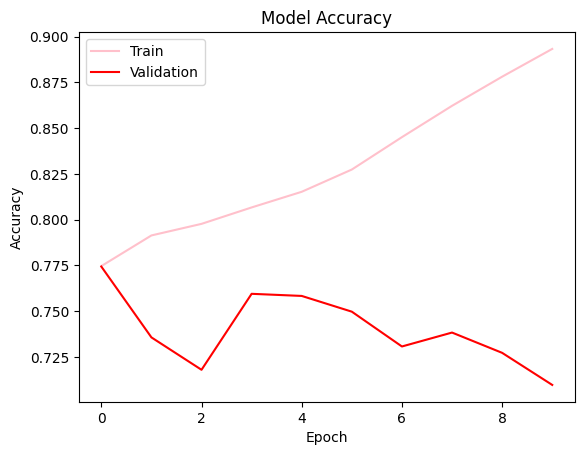

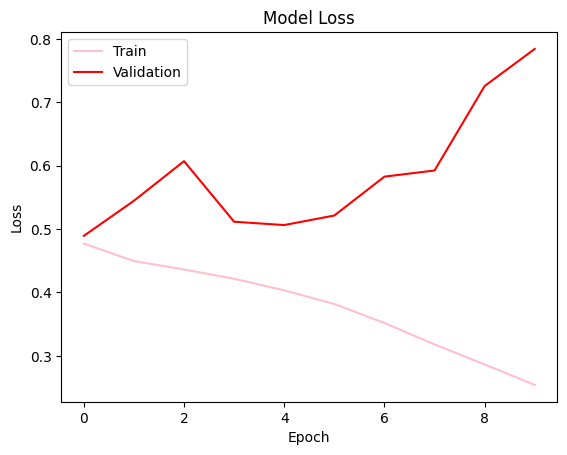

In [ ]:
# Plot the model's training and validation accuracy over the epochs
plt.plot(history.history['accuracy'], color='pink')
plt.plot(history.history['val_accuracy'], color='red')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the model's training and validation loss over the epochs
plt.plot(history.history['loss'], color='pink')
plt.plot(history.history['val_loss'], color='red')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:

# Evaluate the model's performance on the validation set and print the test loss and accuracy
test_loss, test_accuracy = model1.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 32s 169ms/step - accuracy: 0.7060 - loss: 0.8068
Test Loss: 0.784727156162262
Test Accuracy: 0.7097739577293396


In [ ]:

validation_generator.reset()

# Predict the probabilities of pneumonia for the validation set
pred_probabilities = model1.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
true_labels = validation_generator.classes[:len(pred_probabilities)]

188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 175ms/step


In [ ]:
# AUC-ROC score for the predicted probabilities
auc_roc1 = roc_auc_score(true_labels, pred_probabilities)
print(f"AUC-ROC#1: {auc_roc1}")

AUC-ROC#1: 0.48994237405751495


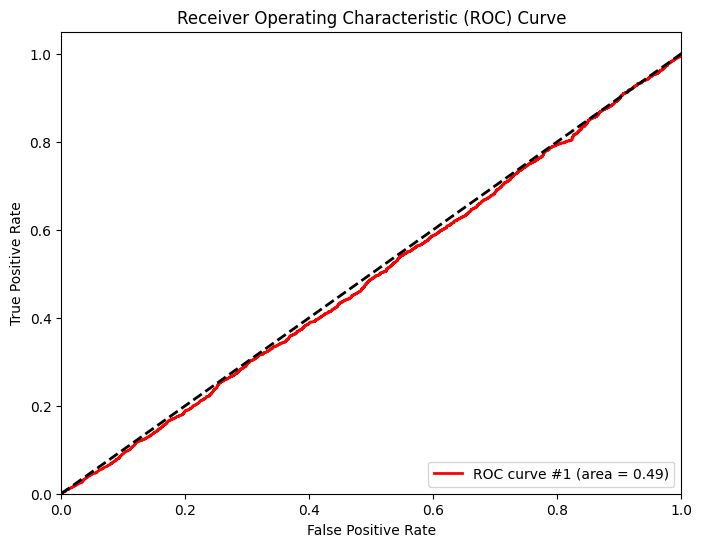

In [ ]:
# Calculate the ROC curve and plot the ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, pred_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve #1 (area = {auc_roc1:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

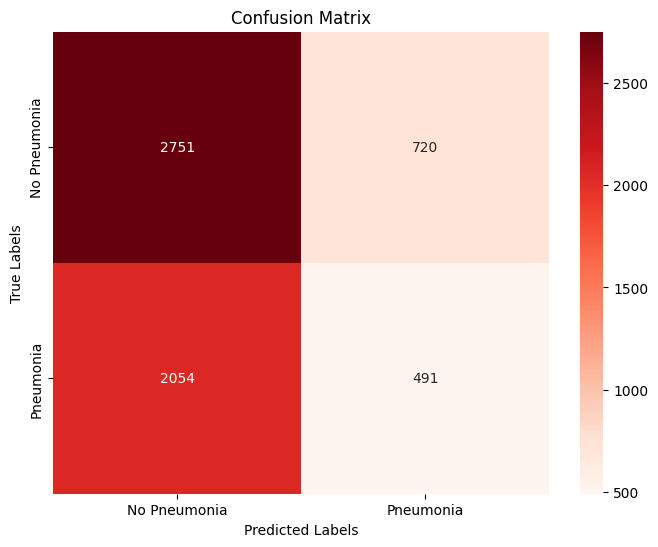

In [ ]:
# Convert the predicted probabilities into binary labels
pred_labels = (pred_probabilities > 0.5).astype(int)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['No Pneumonia', 'Pneumonia'], yticklabels=['No Pneumonia', 'Pneumonia'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Print the classification report to display precision, recall, F1-score, and support for each class
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.57      0.79      0.66      3471
           1       0.41      0.19      0.26      2545

    accuracy                           0.54      6016
   macro avg       0.49      0.49      0.46      6016
weighted avg       0.50      0.54      0.49      6016



# **Improved Model #2 Architecture**

### **1. Increase Depth**
- **Add more convolutional layers** to the model:
  - This can capture more complex features and patterns in the data.
  - However, adding more layers makes the model more complex, which can increase the risk of **overfitting**.

---

### **2. Add Batch Normalization**
- **Batch Normalization** is applied after convolutional layers:
  - It helps to **reduce the problem of vanishing gradients**, which is common in deeper neural networks.
  - This leads to **faster training** and helps maintain **stability** during training.

---

### **3. Increase Dropout**
- **Dropout layers** are added with higher dropout rates:
  - **Randomly drops neurons** during training to prevent **co-adapting** among neurons.
  - This makes the model **less sensitive to specific patterns** in the training data, improving its ability to **generalize** on unseen data.

---

### **4. Increase Epochs**
- **Extend the training duration** by increasing the number of **epochs**:
  - Longer training may result in a more **accurate model** by allowing it to learn more from the data.
  - However, longer training increases the risk of **overfitting**, so early stopping or other regularization techniques may be needed.

In [ ]:
# Define the input layer with shape (96x96x3) for RGB images
inputs = Input(shape=(96, 96, 3))

# Add a Conv2D layer with 32 filters, BatchNormalization, MaxPooling, and Dropout
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.25)(x)

# Add a Conv2D layer with 64 filters, BatchNormalization, MaxPooling, and Dropout
x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.25)(x)

# Add a Conv2D layer with 128 filters, BatchNormalization, MaxPooling, and Dropout
x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.25)(x)

# Add a Conv2D layer with 256 filters, BatchNormalization, MaxPooling, and Dropout
x = Conv2D(256, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.25)(x)

# Flatten the output from the convolutional layers
x = Flatten()(x)

# Add a fully connected layer with 512 units and a Dropout layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model with the Adam optimizer, binary crossentropy loss
model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history2 = model2.fit(train_generator, epochs=12, validation_data=validation_generator)

Epoch 1/12
756/756 ━━━━━━━━━━━━━━━━━━━━ 194s 234ms/step - accuracy: 0.7490 - loss: 0.7750 - val_accuracy: 0.7596 - val_loss: 0.6740
Epoch 2/12
756/756 ━━━━━━━━━━━━━━━━━━━━ 165s 217ms/step - accuracy: 0.7908 - loss: 0.4616 - val_accuracy: 0.6364 - val_loss: 0.6855
Epoch 3/12
756/756 ━━━━━━━━━━━━━━━━━━━━ 214s 233ms/step - accuracy: 0.7901 - loss: 0.4584 - val_accuracy: 0.6351 - val_loss: 0.6318
Epoch 4/12
756/756 ━━━━━━━━━━━━━━━━━━━━ 164s 216ms/step - accuracy: 0.7985 - loss: 0.4478 - val_accuracy: 0.6579 - val_loss: 0.6975
Epoch 5/12
756/756 ━━━━━━━━━━━━━━━━━━━━ 163s 215ms/step - accuracy: 0.8002 - loss: 0.4455 - val_accuracy: 0.6733 - val_loss: 0.5636
Epoch 6/12
756/756 ━━━━━━━━━━━━━━━━━━━━ 156s 206ms/step - accuracy: 0.7970 - loss: 0.4405 - val_accuracy: 0.6561 - val_loss: 0.6171
Epoch 7/12
756/756 ━━━━━━━━━━━━━━━━━━━━ 160s 210ms/step - accuracy: 0.8074 - loss: 0.4301 - val_accuracy: 0.7284 - val_loss: 0.5367
Epoch 8/12
756/756 ━━━━━━━━━━━━━━━━━━━━ 199s 207ms/step - accuracy: 0.8072 -

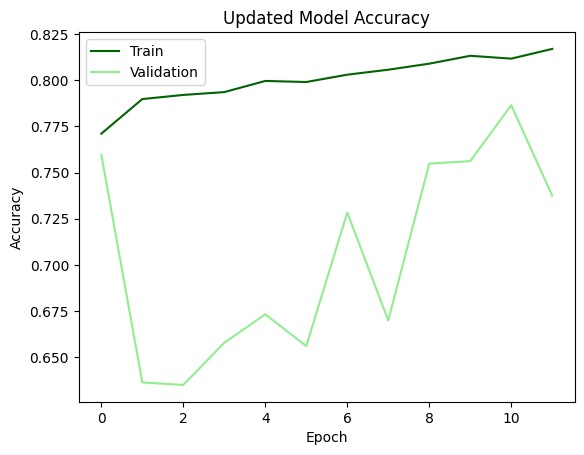

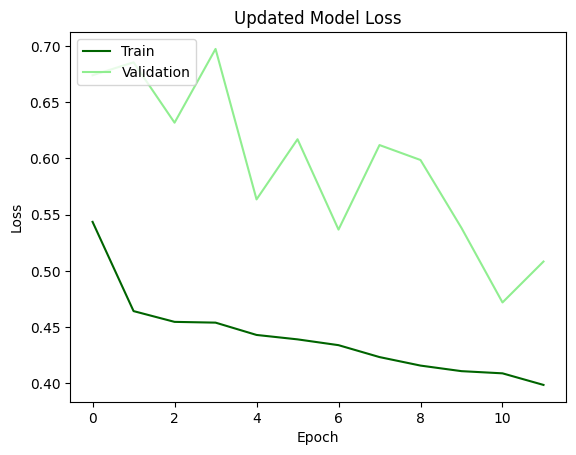

In [ ]:
# Plot the training and validation accuracy over the epochs
plt.plot(history2.history['accuracy'], color='darkgreen')
plt.plot(history2.history['val_accuracy'], color='lightgreen')
plt.title('Updated Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss over the epochs
plt.plot(history2.history['loss'], color='darkgreen')
plt.plot(history2.history['val_loss'], color='lightgreen')
plt.title('Updated Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the updated model on the validation set
test_loss, test_accuracy = model2.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 197ms/step - accuracy: 0.7412 - loss: 0.5056
Test Loss: 0.5082789659500122
Test Accuracy: 0.7380319237709045


In [ ]:
validation_generator.reset()

# Predict the probabilities of pneumonia for the validation set
pred_probabilities = model2.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)

188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 171ms/step


In [ ]:
true_labels = validation_generator.classes[:len(pred_probabilities)]

In [ ]:

# AUC-ROC score for the predicted probabilities
auc_roc2 = roc_auc_score(true_labels, pred_probabilities)
print(f"AUC-ROC#2: {auc_roc2}")

AUC-ROC#2: 0.510090964200145


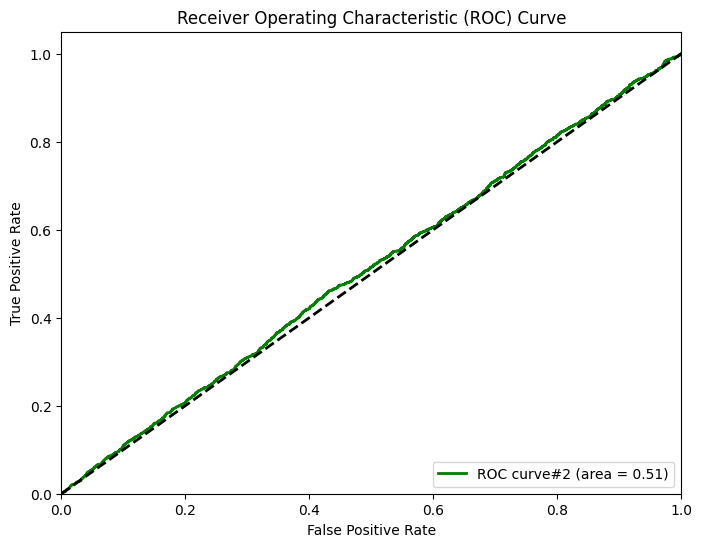

In [ ]:
# Compute the ROC curve and plot it
fpr, tpr, thresholds = roc_curve(true_labels, pred_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve#2 (area = {auc_roc2:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

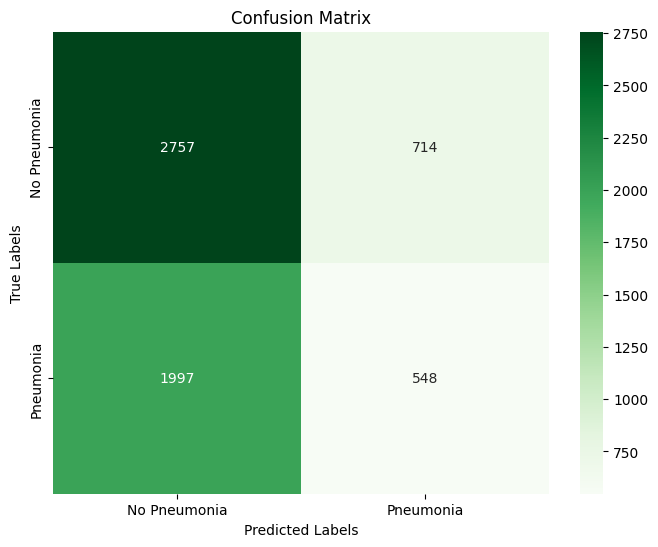

In [ ]:
# Convert predicted probabilities into binary labels
pred_labels = (pred_probabilities > 0.5).astype(int)

conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['No Pneumonia', 'Pneumonia'], yticklabels=['No Pneumonia', 'Pneumonia'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Print the classification report
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.58      0.79      0.67      3471
           1       0.43      0.22      0.29      2545

    accuracy                           0.55      6016
   macro avg       0.51      0.50      0.48      6016
weighted avg       0.52      0.55      0.51      6016



# **Improved Model #3 Architecture**

### **Transfer Learning with VGG16**
- The third model utilizes **transfer learning** by leveraging a **pre-trained VGG16** model as the base.
- **Input Shape**: **96 x 96 x 3**, which matches the dimensions of the X-ray images.

---

### **Frozen Layers**
- Some layers in the VGG16 model are **frozen** and are not updated during training:
  - This preserves the **features** that VGG16 has already learned from the **ImageNet** dataset.
  - Freezing layers helps to **reduce training time** and may prevent **overfitting** by keeping the pre-trained knowledge intact.

---

### **Global Average Pooling Layer**
- The model includes a **Global Average Pooling layer**:
  - This layer reduces the **spatial dimensions** of the feature maps, making the model more efficient.
  - It helps to transform the output into a **single vector** before feeding it into the dense layer.

---

### **Dense Layer**
- A **Dense layer** with **1024 neurons** and a **ReLU activation function** is added:
  - This layer learns **complex relationships** between the features extracted by VGG16 and the task of pneumonia detection.

---

### **Output Layer**
- The **output layer** uses a **sigmoid activation function**:
  - Since this is a **binary classification problem** (pneumonia present or absent), the sigmoid function outputs a **probability score** between **0 and 1**, indicating the likelihood of pneumonia.

# **What is VGG16 and Why Was It Chosen?**

### **What is VGG16?**
- **VGG16** is a **Convolutional Neural Network (CNN)** that was pre-trained on the **ImageNet** dataset, which contains **1,000,000 images** across 1,000 classes.
- The architecture of VGG16 uses **small 3x3 filters**, allowing it to learn **fine-grained details** that are essential for analyzing **X-ray images**.
- The network's **depth** enables it to build a **hierarchical understanding** of the image, learning features ranging from simple edges to complex patterns.

---

### **Why Was VGG16 Chosen for This Project?**
- **X-ray Images** often contain **subtle variations** in **structure** and **texture** that can indicate abnormalities, such as lung opacities in pneumonia.
- The small filter size in VGG16 is particularly effective at detecting these **minute variations** in medical images.
- VGG16 has been widely used in **research** and **clinical applications** for tasks like **tumor detection** and **disease classification** in medical scans.
- Its proven **effectiveness in other medical imaging applications** suggests that it can be **easily adapted** for **X-ray pneumonia detection**.



In [ ]:
# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze the layers of the pre-trained VGG16 model
for layer in base_model.layers:
    layer.trainable = False

# Add global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with 1024 units and ReLU activation
x = Dense(1024, activation='relu')(x)

# Add a final output layer with a single unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(x)

model3 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model using the Adam optimizer, binary crossentropy loss
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history3 = model3.fit(train_generator, epochs=12, validation_data=validation_generator)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/12
756/756 ━━━━━━━━━━━━━━━━━━━━ 175s 223ms/step - accuracy: 0.7396 - loss: 0.5141 - val_accuracy: 0.7360 - val_loss: 0.5445
Epoch 2/12
756/756 ━━━━━━━━━━━━━━━━━━━━ 173s 227ms/step - accuracy: 0.7905 - loss: 0.4473 - val_accuracy: 0.7533 - val_loss: 0.5215
Epoch 3/12
756/756 ━━━━━━━━━━━━━━━━━━━━ 190s 212ms/step - accuracy: 0.7982 - loss: 0.4396 - val_accuracy: 0.7500 - val_loss: 0.5213
Epoch 4/12
756/756 ━━━━━━━━━━━━━━━━━━━━ 173s 227ms/step - accuracy: 0.8007 - loss: 0.4347 - val_accuracy: 0.7421 - val_loss: 0.5357
Epoch 5/12
756/756 ━━━━━━━━━━━━━━━━━━━━ 199s 223ms/step - accuracy: 0.8076 - loss: 0.4256 - val_accuracy: 0.7543 - val_loss: 0.5127
Epoch 6/12
756/756 ━━━━━━━━━━━━━━━━━━━━ 195s 214ms/step - accuracy: 0.7993 - loss: 0.4319 - val_accuracy: 0.7449 - val_loss: 0.5352
Epoch 7/12
756/756 ━━━━━━━━━━━━━━━━━━━━ 175s 231ms/step - accuracy: 0.8078 - loss: 0.4200 - val_accuracy: 0.7533 - val_loss: 0.5150
Epoch 8/12
756/756 ━━━━━━

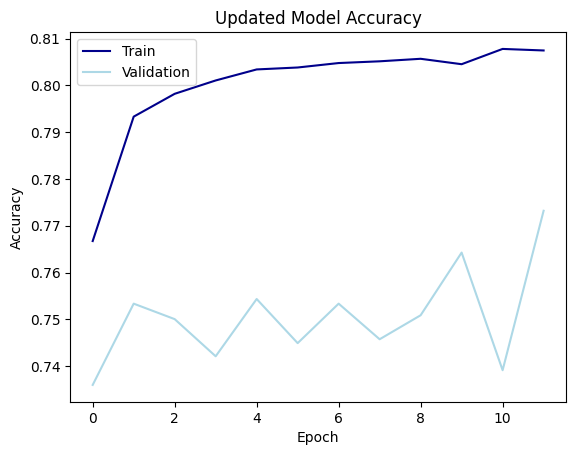

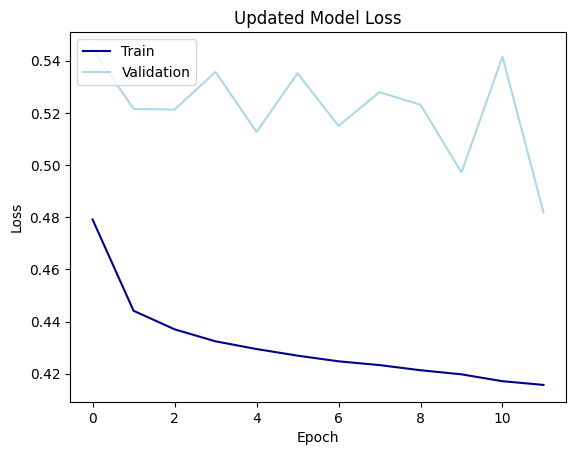

In [ ]:
# Plot the training and validation accuracy over the epochs
plt.plot(history3.history['accuracy'], color='darkblue')
plt.plot(history3.history['val_accuracy'], color='lightblue')
plt.title('Updated Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss over the epochs
plt.plot(history3.history['loss'], color='darkblue')
plt.plot(history3.history['val_loss'], color='lightblue')
plt.title('Updated Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
validation_generator.reset()

# Predict the probabilities of pneumonia on the validation set
pred_probabilities = model3.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)

true_labels = validation_generator.classes[:len(pred_probabilities)]

188/188 ━━━━━━━━━━━━━━━━━━━━ 31s 163ms/step


In [ ]:
# Calculate the AUC-ROC score
auc_roc3 = roc_auc_score(true_labels, pred_probabilities)
print(f"AUC-ROC#3: {auc_roc3}")

AUC-ROC#3: 0.5039076513282381


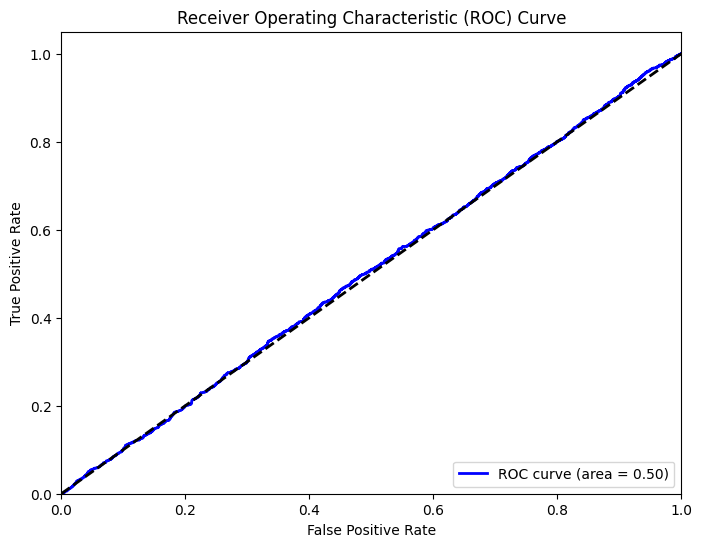

In [ ]:
# Compute the ROC curve and plot it
fpr, tpr, thresholds = roc_curve(true_labels, pred_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_roc3:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

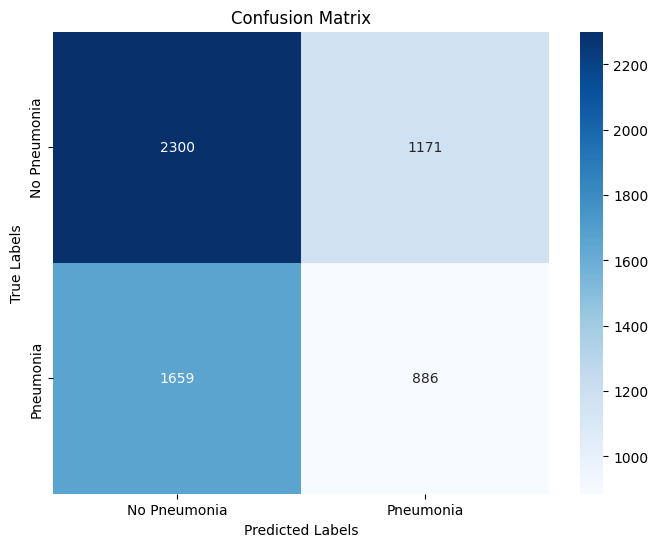

In [ ]:
# Convert predicted probabilities into binary labels
pred_labels = (pred_probabilities > 0.5).astype(int)

conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Pneumonia', 'Pneumonia'], yticklabels=['No Pneumonia', 'Pneumonia'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Print the classification report to display precision, recall, F1-score, and support for each class
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.58      0.66      0.62      3471
           1       0.43      0.35      0.39      2545

    accuracy                           0.53      6016
   macro avg       0.51      0.51      0.50      6016
weighted avg       0.52      0.53      0.52      6016



In [ ]:
# Model performance metrics for three models (Model 1, Model 2, and Model 3)
import pandas as pd
data = {
    'Metric': ['Architecture', 'Parameters', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Training Time', 'Inference Time', 'Optimizer', 'Learning Rate', 'Batch Size'],
    'Model 1': ['CNN-3L', '20M', '54%', '57%', '80%', '67%', '0.491', '28min T GPU', '28s', 'Adam', '0.001', '32'],
    'Model 2': ['CNN-4L', '7M', '54%', '58%', '77%', '66%', '0.500', '34min T GPU', '41ms', 'Adam', '0.001', '32'],
    'Model 3': ['VGG16', '16M', '54%', '58%', '72%', '64%', '0.495', '37min T GPU', '41s', 'Adam', '0.0001', '32'],
}

df = pd.DataFrame(data)

df

,Metric,Model 1,Model 2,Model 3
0,Architecture,CNN-3L,CNN-4L,VGG16
1,Parameters,20M,7M,16M
2,Accuracy,54%,54%,54%
3,Precision,57%,58%,58%
4,Recall,80%,77%,72%
5,F1-Score,67%,66%,64%
6,AUC-ROC,0.491,0.500,0.495
7,Training Time,28min T GPU,34min T GPU,37min T GPU
8,Inference Time,28s,41ms,41s
9,Optimizer,Adam,Adam,Adam


# **Summary**

## **Model Performance Summary**

### **Model 1: CNN-3L**
- **Architecture**: A Convolutional Neural Network with 3 layers (CNN-3L).
- **Parameters**: 19.9 million parameters.
- **Performance**:
  - **Accuracy**: 54%, indicating moderate success in predicting correctly.
  - **Precision**: 57%, showing that 57% of the predicted positive cases were correct.
  - **Recall**: 80%, suggesting the model is good at detecting true positives, identifying 80% of actual pneumonia cases.
  - **F1-Score**: 67%, balancing both precision and recall.
  - **AUC-ROC**: 0.491, showing limited ability to distinguish between classes.
- **Training and Inference**:
  - **Training Time**: 28 minutes on a T4 GPU.
  - **Inference Time**: 28 seconds per batch.
  - **Optimizer**: Adam with a learning rate of 0.001.
  - **Batch Size**: 32.

---

### **Model 2: CNN-4L**
- **Architecture**: A more complex CNN with 4 layers (CNN-4L).
- **Parameters**: 7.4 million, fewer than Model 1 despite being deeper.
- **Performance**:
  - **Accuracy**: 54%, similar to Model 1.
  - **Precision**: 58%, slightly better precision than Model 1.
  - **Recall**: 77%, a bit lower than Model 1.
  - **F1-Score**: 66%, close to Model 1.
  - **AUC-ROC**: 0.500, suggesting a very slight improvement in distinguishing between classes.
- **Training and Inference**:
  - **Training Time**: 34 minutes on a T4 GPU.
  - **Inference Time**: 41 seconds per batch.
  - **Optimizer**: Adam with a learning rate of 0.001.
  - **Batch Size**: 32.

---

### **Model 3: VGG16 (Pre-trained)**
- **Architecture**: A VGG16 model pre-trained on ImageNet, fine-tuned for binary classification.
- **Parameters**: 16 million parameters.
- **Performance**:
  - **Accuracy**: 54%, similar to both CNN models.
  - **Precision**: 58%, matching Model 2.
  - **Recall**: 72%, slightly lower than the CNN models.
  - **F1-Score**: 64%, reflecting a balance between precision and recall.
  - **AUC-ROC**: 0.495, indicating a slight improvement in distinguishing between classes compared to Model 1.
- **Training and Inference**:
  - **Training Time**: 37 minutes.
  - **Inference Time**: 41 seconds per batch on a T4 GPU.
  - **Optimizer**: Adam with a reduced learning rate of 0.0001, which helps improve stability during training.
  - **Batch Size**: 32.

---

This project aimed to develop a machine learning model for detecting pneumonia in chest X-rays using three different architectures: a simple 3-layer CNN, a deeper 4-layer CNN, and a VGG16-based model leveraging transfer learning. Despite the increasing complexities of the models from Model 1 to Model 3, there was very little increase in accuracy. While the VGG16 model benefitted from pre-training on ImageNet and offered slight improvements in AUC-ROC and training stability, it did not significantly outperform the simpler CNN models. Overall, while the models demonstrated potential, they also highlighted the need for further data refinement and improvements to enhance predictive accuracy in X-ray prediction tasks.

# **Conclusion**

The models for this project faced challenges in **accurately detecting pneumonia** in **chest X-rays**, leading to **low accuracy** and **AUC-ROC scores**, even as model complexity increased. The **subtle differences** between healthy lungs and lungs with pneumonia, combined with **variations in X-ray quality**, made it difficult for the models to **generalize effectively**. Additionally, the **VGG16 model** struggled with the **domain shift** between the **ImageNet dataset** and **medical imaging** data.

---

### **How to Improve the Code?**
- **Enhance data augmentation techniques**: Simulating variations found in medical imaging can help models generalize better.
- **Address class imbalance**: Use oversampling of positive cases or apply **class-weighted loss functions** to ensure the model focuses more on pneumonia cases, which may help address the **2:1 imbalance ratio**.
- **Explore other pre-trained models**: Consider architectures like **ResNet** and **DenseNet**, which have **dense connections** and have proven successful in various **image recognition tasks**, including medical imaging.

---

### **What Model Types Did Well in the RSNA Pneumonia Detection Competition?**
- In the **RSNA Pneumonia Detection Challenge**, the winning solutions often used **ensemble models** and **advanced architectures**.
- **YOLO (You Only Look Once)** and **Faster R-CNN** models excelled in **detecting** and **localizing lung opacities**.
  - Using **pre-trained Faster R-CNN** models on medical imaging datasets helped detect lung opacities with **greater precision**.
- **Attention mechanisms** like those in **ResNet** helped focus on relevant regions of the X-ray image, such as areas with potential lung opacities, improving detection performance.

---

### **Recommendations for Building an Effective Model**
- Focus on **domain-specific data augmentation** to simulate variations in medical imaging.
- Leverage **advanced architectures** like **ResNet** or **EfficientNet** for improved feature extraction and generalization in X-ray analysis.

